In [37]:
#@title Copyright 2019 The Lifetime Value Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Lifetime Value prediction for Kaggle Acquire Valued Customer Challenge

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import tqdm
from typing import Sequence

import lifetime_value as ltv

In [3]:
tfd = tfp.distributions
%config InlineBackend.figure_format='retina'
sns.set_style('whitegrid')
pd.options.mode.chained_assignment = None  # default='warn'

## Global variables

In [4]:
COMPANY = '104900040'  # @param { isTemplate: true, type: 'string'}
LOSS = 'ziln'  # @param { isTemplate: true, type: 'string'} ['mse', 'ziln']
MODEL = 'dnn'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn']
LEARNING_RATE = 0.0002  # @param { isTemplate: true}
EPOCHS = 400  # @param { isTemplate: true, type: 'integer'}
OUTPUT_CSV_FOLDER = '/tmp/lifetime-value/acquire-valued-shoppers-challenge/result'  # @param { isTemplate: true, type: 'string'}

In [5]:
CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
NUMERIC_FEATURES = ['log_calibration_value']

ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

## Data

### Download data

Setup kaggle API correctly following https://www.kaggle.com/docs/api
```
%%shell
mkdir ~/.kaggle
echo \{\"username\":\"{your kaggle username}\",\"key\":\"{your kaggle api key}\"\} > ~/.kaggle/kaggle.json
pip install kaggle
```

In [6]:
# %%shell
# if [ -e /tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions.csv ]
# then
#   echo "File already exists, no need to download."
# else
#   rm -rf /tmp/lifetime-value/acquire-valued-shoppers-challenge
#   mkdir -p /tmp/lifetime-value/acquire-valued-shoppers-challenge
#   cd /tmp/lifetime-value/acquire-valued-shoppers-challenge
#   kaggle competitions download -c acquire-valued-shoppers-challenge
#   echo "Unzip file. This may take 10 min."
#   gunzip transactions.csv.gz
# fi

### Load transaction csv

In [7]:
def load_transaction_data(company):
  all_data_filename = '/tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions.csv'
  one_company_data_filename = (
      '/tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions_company_{}.csv'
      .format(COMPANY))
  if os.path.isfile(one_company_data_filename):
    df = pd.read_csv(one_company_data_filename)
  else:
    data_list = []
    chunksize = 10**6
    # 350 iterations
    for chunk in tqdm.tqdm(pd.read_csv(all_data_filename, chunksize=chunksize)):
      data_list.append(chunk.query("company=={}".format(company)))
    df = pd.concat(data_list, axis=0)
    df.to_csv(one_company_data_filename, index=None)
  return df

### Preprocess data

In [8]:
def preprocess(df):
  df = df.query('purchaseamount>0')
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
  df['start_date'] = df.groupby('id')['date'].transform('min')

  # Compute calibration values
  calibration_value = (
      df.query('date==start_date').groupby('id')
      ['purchaseamount'].sum().reset_index())
  calibration_value.columns = ['id', 'calibration_value']

  # Compute holdout values
  one_year_holdout_window_mask = (
      (df['date'] > df['start_date']) &
      (df['date'] <= df['start_date'] + np.timedelta64(365, 'D')))
  holdout_value = (
      df[one_year_holdout_window_mask].groupby('id')
      ['purchaseamount'].sum().reset_index())
  holdout_value.columns = ['id', 'holdout_value']

  # Compute calibration attributes
  calibration_attributes = (
      df.query('date==start_date').sort_values(
          'purchaseamount', ascending=False).groupby('id')[[
              'chain', 'dept', 'category', 'brand', 'productmeasure'
          ]].first().reset_index())

  # Merge dataframes
  customer_level_data = (
      calibration_value.merge(calibration_attributes, how='left',
                              on='id').merge(
                                  holdout_value, how='left', on='id'))
  customer_level_data['holdout_value'] = (
      customer_level_data['holdout_value'].fillna(0.))
  customer_level_data[CATEGORICAL_FEATURES] = (
      customer_level_data[CATEGORICAL_FEATURES].fillna('UNKNOWN'))

  # Specify data types
  customer_level_data['log_calibration_value'] = (
      np.log(customer_level_data['calibration_value']).astype('float32'))
  customer_level_data['chain'] = (
      customer_level_data['chain'].astype('category'))
  customer_level_data['dept'] = (customer_level_data['dept'].astype('category'))
  customer_level_data['brand'] = (
      customer_level_data['brand'].astype('category'))
  customer_level_data['category'] = (
      customer_level_data['category'].astype('category'))
  customer_level_data['label'] = (
      customer_level_data['holdout_value'].astype('float32'))
  return customer_level_data

### Load customer-level csv

In [9]:
def load_customer_level_csv(company):
  customer_level_data_file = (
      '/tmp/lifetime-value/acquire-valued-shoppers-challenge/customer_level_data_company_{}.csv'
      .format(company))
  if os.path.isfile(customer_level_data_file):
    customer_level_data = pd.read_csv(customer_level_data_file)
  else:
    customer_level_data = preprocess(load_transaction_data(company))
  for cat_col in CATEGORICAL_FEATURES:
    customer_level_data[cat_col] = (
        customer_level_data[cat_col].astype('category'))
  for num_col in [
      'log_calibration_value', 'calibration_value', 'holdout_value'
  ]:
    customer_level_data[num_col] = (
        customer_level_data[num_col].astype('float32'))

  return customer_level_data

In [10]:
# Processes data. 350 iteration in total. May take 10min.
customer_level_data = load_customer_level_csv(COMPANY)

We observe a mixture of zero and lognormal distribution of holdout value.

<Axes: >

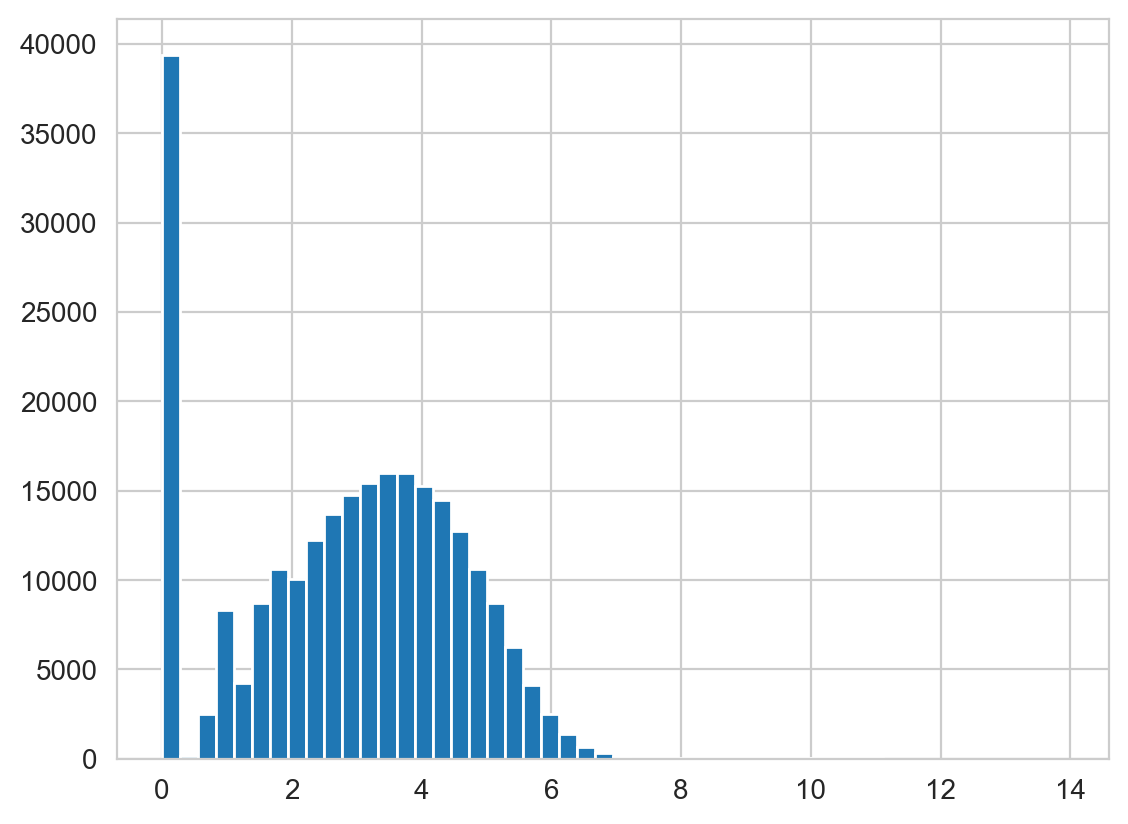

In [11]:
customer_level_data.label.apply(np.log1p).hist(bins=50)

### Make train/eval

In [12]:
def linear_split(df):
  # get_dummies preserves numeric features.
  x = pd.get_dummies(df[ALL_FEATURES], drop_first=True).astype('float32').values
  y = df['label'].values
  y0 = df['calibration_value'].values

  x_train, x_eval, y_train, y_eval, y0_train, y0_eval = (
      model_selection.train_test_split(
          x, y, y0, test_size=0.2, random_state=123))

  return x_train, x_eval, y_train, y_eval, y0_eval

In [13]:
def dnn_split(df):
  for key in CATEGORICAL_FEATURES:
    encoder = preprocessing.LabelEncoder()
    df[key] = encoder.fit_transform(df[key])

  y0 = df['calibration_value'].values
  df_train, df_eval, y0_train, y0_eval = model_selection.train_test_split(
      df, y0, test_size=0.2, random_state=123)

  def feature_dict(df):
    features = {k: v.values for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
    features['numeric'] = df[NUMERIC_FEATURES].values
    return features

  x_train, y_train = feature_dict(df_train), df_train['label'].values
  x_eval, y_eval = feature_dict(df_eval), df_eval['label'].values

  return x_train, x_eval, y_train, y_eval, y0_eval

## Model

In [14]:
def linear_model(output_units):
  return tf.keras.experimental.LinearModel(output_units)

In [15]:
def embedding_dim(x):
  return int(x**.25) + 1


def embedding_layer(vocab_size):
  return tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim(vocab_size),
          input_length=1),
      tf.keras.layers.Flatten(),
  ])


def dnn_model(output_units, df):
  numeric_input = tf.keras.layers.Input(
      shape=(len(NUMERIC_FEATURES),), name='numeric')

  embedding_inputs = [
      tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
      for key in CATEGORICAL_FEATURES
  ]

  embedding_outputs = [
      embedding_layer(vocab_size=df[key].nunique())(input)
      for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
  ]

  deep_input = tf.keras.layers.concatenate([numeric_input] + embedding_outputs)
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(output_units),
  ])
  return tf.keras.Model(
      inputs=[numeric_input] + embedding_inputs, outputs=deep_model(deep_input))

### Train

In [16]:
if LOSS == 'mse':
  loss = keras.losses.MeanSquaredError()
  output_units = 1

if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [17]:
if MODEL == 'linear':
  x_train, x_eval, y_train, y_eval, y0_eval = linear_split(customer_level_data)
  model = linear_model(output_units)

if MODEL == 'dnn':
  x_train, x_eval, y_train, y_eval, y0_eval = dnn_split(customer_level_data)
  model = dnn_model(output_units, customer_level_data)

In [18]:
model.compile(loss=loss, optimizer=keras.optimizers.Adam(lr=LEARNING_RATE))

In [19]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [20]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=1024,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval)).history

Epoch 1/400
195/195 - 1s - loss: 5.7248 - val_loss: 4.6484 - lr: 0.0010 - 739ms/epoch - 4ms/step
Epoch 2/400
195/195 - 0s - loss: 4.6153 - val_loss: 4.6213 - lr: 0.0010 - 212ms/epoch - 1ms/step
Epoch 3/400
195/195 - 0s - loss: 4.6064 - val_loss: 4.6168 - lr: 0.0010 - 214ms/epoch - 1ms/step
Epoch 4/400
195/195 - 0s - loss: 4.6042 - val_loss: 4.6158 - lr: 0.0010 - 209ms/epoch - 1ms/step
Epoch 5/400
195/195 - 0s - loss: 4.6032 - val_loss: 4.6154 - lr: 0.0010 - 211ms/epoch - 1ms/step
Epoch 6/400
195/195 - 0s - loss: 4.6023 - val_loss: 4.6158 - lr: 0.0010 - 216ms/epoch - 1ms/step
Epoch 7/400
195/195 - 0s - loss: 4.6020 - val_loss: 4.6163 - lr: 0.0010 - 215ms/epoch - 1ms/step
Epoch 8/400
195/195 - 0s - loss: 4.6021 - val_loss: 4.6154 - lr: 0.0010 - 224ms/epoch - 1ms/step
Epoch 9/400
195/195 - 0s - loss: 4.6017 - val_loss: 4.6143 - lr: 0.0010 - 216ms/epoch - 1ms/step
Epoch 10/400
195/195 - 0s - loss: 4.6015 - val_loss: 4.6142 - lr: 0.0010 - 240ms/epoch - 1ms/step
Epoch 11/400
195/195 - 0s - l

<Axes: >

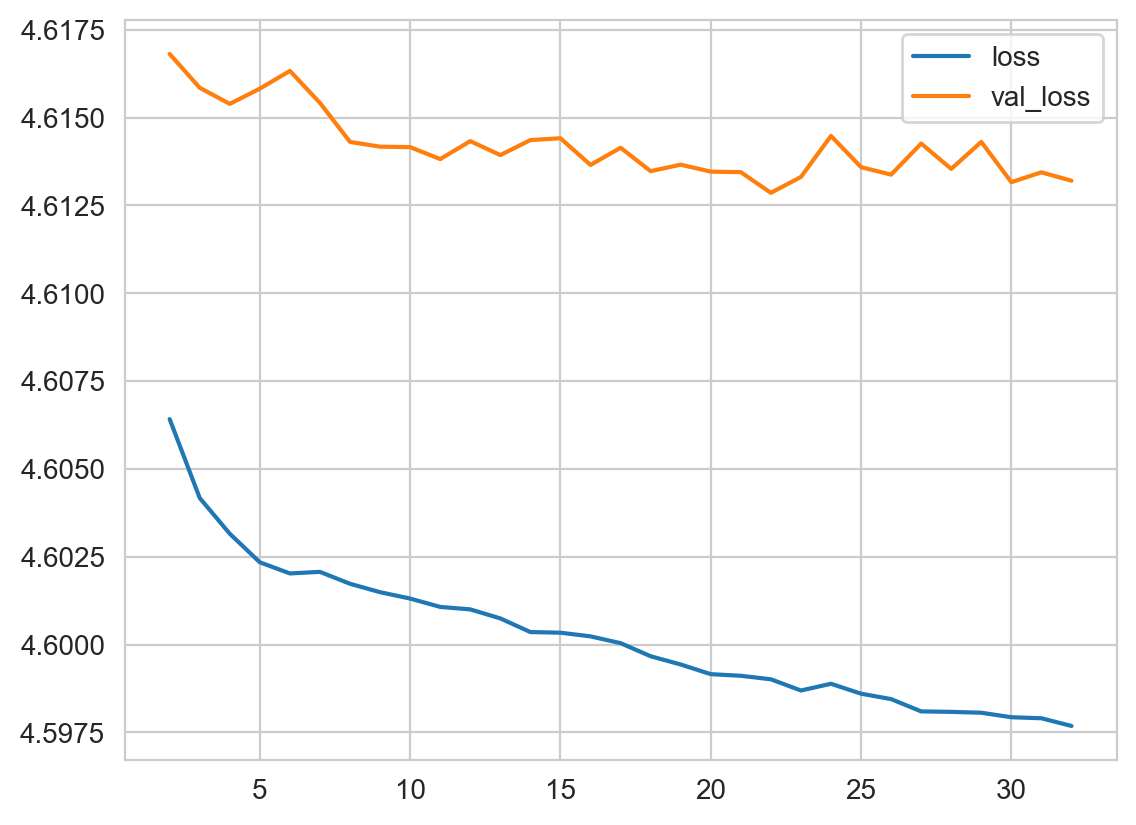

In [21]:
pd.DataFrame(history)[['loss', 'val_loss']][2:].plot()

### Eval

In [22]:
if LOSS == 'mse':
  y_pred = model.predict(x=x_eval, batch_size=1024).flatten()

if LOSS == 'ziln':
  logits = model.predict(x=x_eval, batch_size=1024)
  y_pred = ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()

49/49 [==============================] - 0s 518us/step


In [23]:
df_pred = pd.DataFrame({
    'y_true': y_eval,
    'y_pred': y_pred,
})
df_pred.head(10)

,y_true,y_pred
0,19.209999,51.600605
1,0.000000,53.449787
2,165.000000,66.706337
3,39.849998,81.923653
4,49.840000,65.291832
5,43.080002,43.377148
6,185.179993,81.282600
7,25.840000,54.041073
8,0.000000,47.260036
9,31.780001,40.577702


### Gini Coefficient

In [24]:
gain = pd.DataFrame({
    'lorenz': ltv.cumulative_true(y_eval, y_eval),
    'baseline': ltv.cumulative_true(y_eval, y0_eval),
    'model': ltv.cumulative_true(y_eval, y_pred),
})

In [25]:
num_customers = np.float32(gain.shape[0])
gain['cumulative_customer'] = (np.arange(num_customers) + 1.) / num_customers

Text(0.5, 1.0, 'Gain Chart')

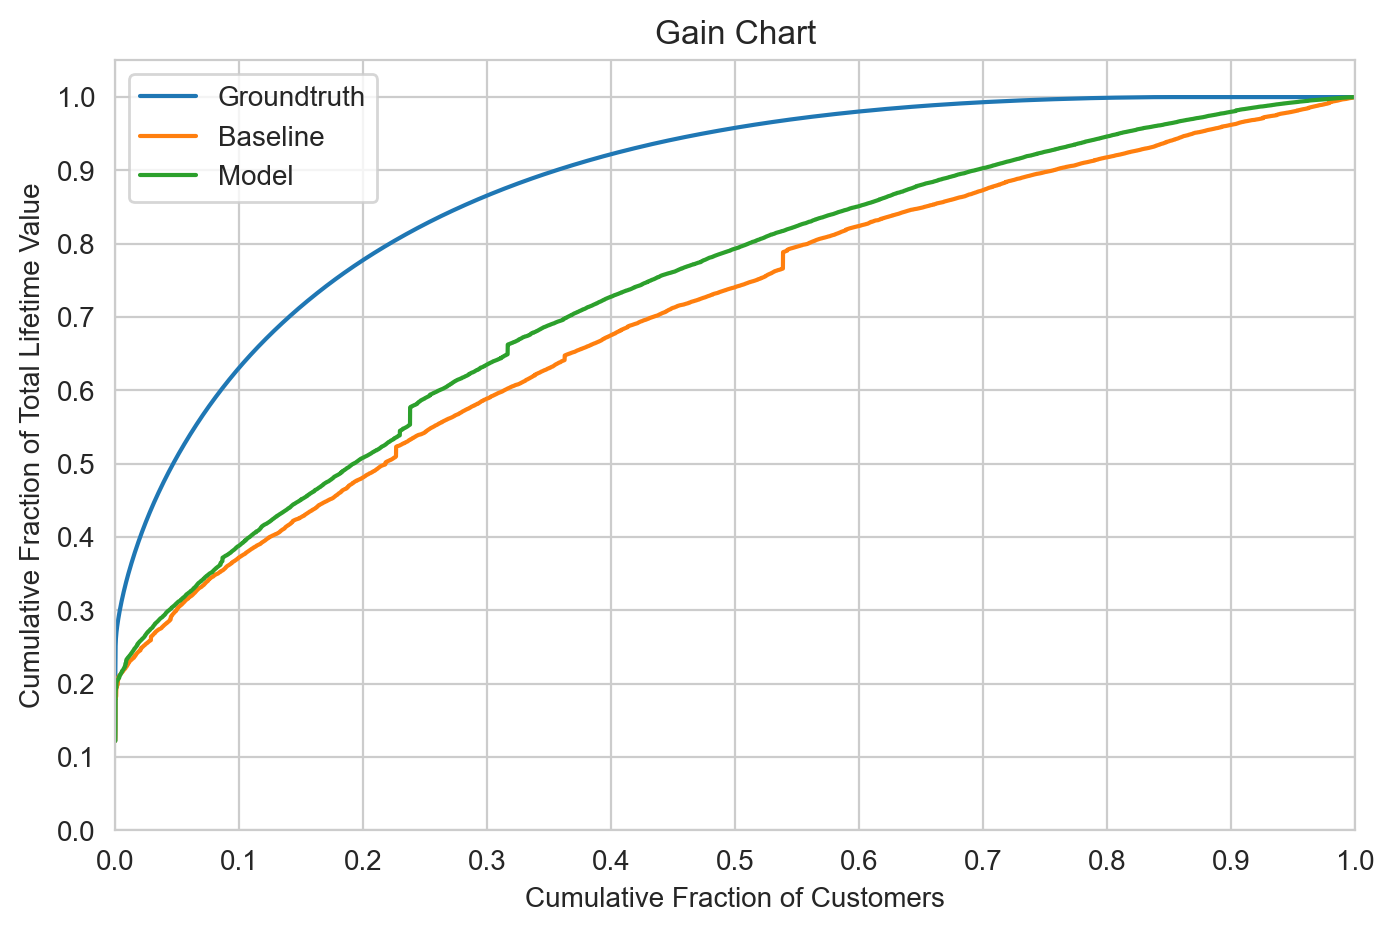

In [26]:
ax = gain[[
    'cumulative_customer',
    'lorenz',
    'baseline',
    'model',
]].plot(
    x='cumulative_customer', figsize=(8, 5), legend=True)

ax.legend(['Groundtruth', 'Baseline', 'Model'], loc='upper left')

ax.set_xlabel('Cumulative Fraction of Customers')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim((0, 1.))

ax.set_ylabel('Cumulative Fraction of Total Lifetime Value')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim((0, 1.05))
ax.set_title('Gain Chart')

In [27]:
gini = ltv.gini_from_gain(gain[['lorenz', 'baseline', 'model']])
gini

,raw,normalized
lorenz,0.764284,1.000000
baseline,0.411868,0.538895
model,0.473165,0.619096


### Calibration

In [28]:
df_decile = ltv.decile_stats(y_eval, y_pred)
df_decile

,label_mean,pred_mean,normalized_rmse,normalized_mae,decile_mape
decile,,,,,
0,14.647440,13.904985,3.329770,1.115096,0.050688
1,24.557680,25.482290,1.864679,1.075135,0.037651
2,31.546944,34.045647,1.911448,1.071848,0.079206
3,37.985615,41.453270,1.727218,1.051230,0.091289
4,42.437492,48.508522,1.530118,1.038578,0.143058
5,47.726963,56.600986,1.582208,1.035207,0.185933
6,67.723946,66.908081,10.020801,1.004174,0.012047
7,92.783470,81.100441,12.942814,0.975931,0.125917
8,87.732986,102.286667,1.450182,0.964219,0.165886


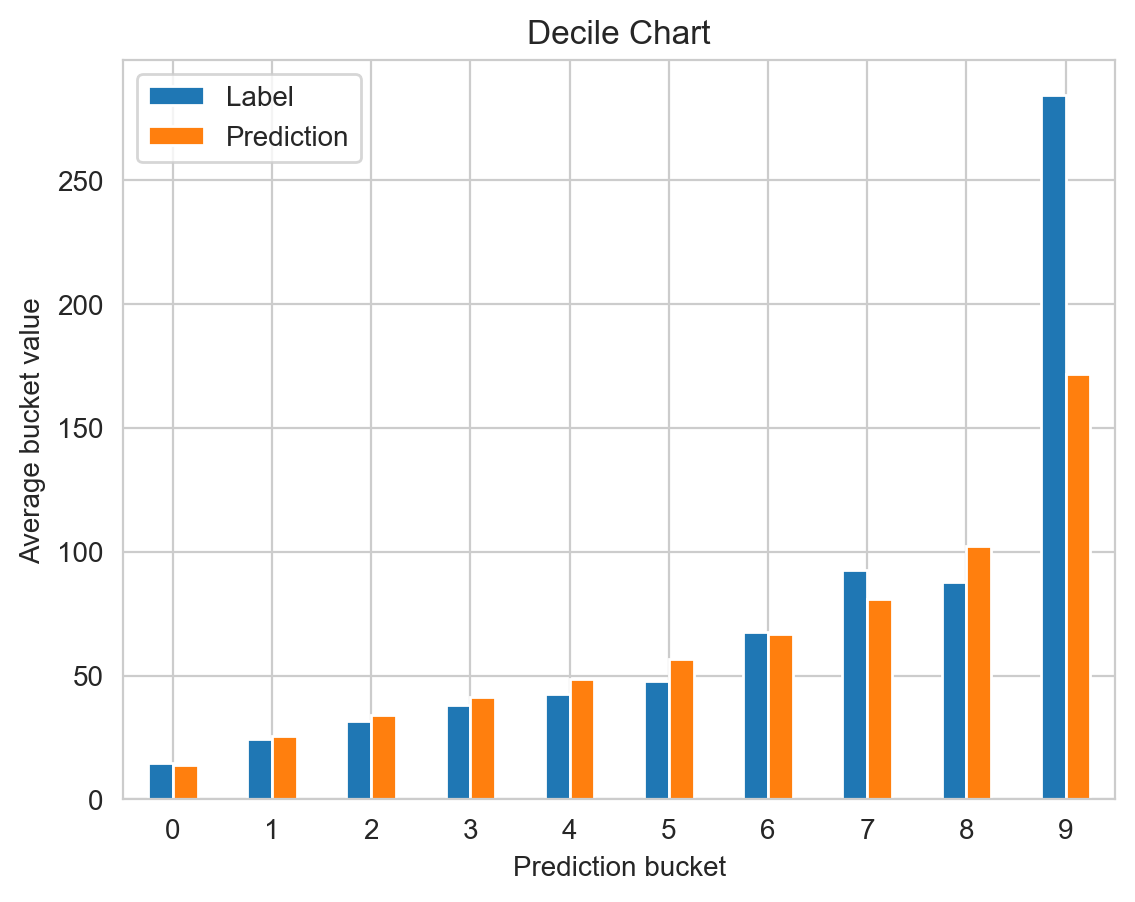

In [29]:
ax = df_decile[['label_mean', 'pred_mean']].plot.bar(rot=0)

ax.set_title('Decile Chart')
ax.set_xlabel('Prediction bucket')
ax.set_ylabel('Average bucket value')
ax.legend(['Label', 'Prediction'], loc='upper left')

### Rank Correlation

In [30]:
def spearmanr(x1: Sequence[float], x2: Sequence[float]) -> float:
  """Calculates spearmanr rank correlation coefficient.

  See https://docs.scipy.org/doc/scipy/reference/stats.html.

  Args:
    x1: 1D array_like.
    x2: 1D array_like.

  Returns:
    correlation: float.
  """
  return stats.spearmanr(x1, x2, nan_policy='raise')[0]


spearman_corr = spearmanr(y_eval, y_pred)
spearman_corr

0.3900887937883124

### All metrics together

In [31]:
df_metrics = pd.DataFrame(
    {
        'company': COMPANY,
        'model': MODEL,
        'loss': LOSS,
        'label_mean': y_eval.mean(),
        'pred_mean': y_pred.mean(),
        'label_positive': np.mean(y_eval > 0),
        'decile_mape': df_decile['decile_mape'].mean(),
        'baseline_gini': gini['normalized'][1],
        'gini': gini['normalized'][2],
        'spearman_corr': spearman_corr,
    },
    index=[0])

In [32]:
df_metrics[[
    'company',
    'model',
    'loss',
    'label_mean',
    'pred_mean',
    'label_positive',
    'decile_mape',
    'baseline_gini',
    'gini',
    'spearman_corr',
]]

,company,model,loss,label_mean,pred_mean,label_positive,decile_mape,baseline_gini,gini,spearman_corr
0,104900040,dnn,ziln,73.107872,64.173332,0.844395,0.128777,0.538895,0.619096,0.390089


## Save

In [33]:
output_path = os.path.join(OUTPUT_CSV_FOLDER, COMPANY)

In [34]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [35]:
output_file = os.path.join(output_path,
                           '{}_regression_{}.csv'.format(MODEL, LOSS))

In [36]:
df_metrics.to_csv(output_file, index=False)